# Simple Model Cavity




The simplest model is that of the wave equation in a box. 

$$
\partial_t^2 u = \Delta u
$$

The energy is given by,

$$
\mathcal{E} := \frac{1}{2}\int_V [(\partial_t u)^2 + \nabla u \cdot \nabla u]\; dV
$$

Thus, 

$$
\frac{d\mathcal{E}}{dt} = \int_{\partial V} \partial_t u \; \vec{N}\cdot \nabla u \; dS
$$

Thus, boundary conditions of the type:

$$
-a \partial_t u = \vec{N}\cdot \nabla u
$$
are stable for they bound the energy. 

We want to find the cavity frequencies with boundary conditions of this type. It is expected that for $ a \neq 0$ the frequencies will have a decaying imaginary part.
To do this we propose the solutions are of the form:

$$
u = u_j e^{i\omega_j t}
$$
and get the system:

\begin{eqnarray*}
\Delta u_j &=& -\omega_j^2 u_j \;\;\;\; \in V \\
\vec{N}\cdot \nabla u &=& -ia \omega_j u_j \;\;\;\; \in \partial S
\end{eqnarray*}



### Note: 

This is not yet an eigenvalue problem for the eigenvalue and its square appear.

### Note: 

in electromagnetism there are conditions like,

$$
\vec{N}\cdot \nabla u = a\sqrt{\omega_j} u_j \;\;\;\; \in \partial S
$$
so eventually we will have to deal with that too.

To get a normal eigenvalue problem we introduce 
$$
p_j := i \omega_j u_j
$$
and the system becomes,

\begin{eqnarray*}
\Delta u_j &=& i\omega_j p_j \;\;\;\; \in V \\
p_j &=& i \omega_j u_j \\
\vec{N}\cdot \nabla u &=& -a p_j \;\;\;\; \in \partial S
\end{eqnarray*}

This system is hermitian for $a=0$, and $a \to \infty$ but otherwise it is not, so the standard theory does not apply.

### Numerical considerations - Fenics

For the Fenics implementation we look at the weak problem:

$$
\int_V [u_T p_j +  p_T \Delta u_j]\; dV + \int_{\partial V} p_T(\vec{N}\cdot u_j - p_j/a) \; dS = i \omega_j \int_V [ u_T u_j + p_T p_j]
$$

Which becomes, 

$$
\int_V [u_T p_j  - \nabla  p_T \cdot \nabla u_j]\; dV - \int_{\partial V} a p_T  p_j) \; dS = i \omega_j \int_V [ u_T u_j + p_T p_j]
$$


### Status

Test: is working ok. 

Rectagle: is working but we don't have exact solutions to check.

open_cavity: not done yet.

In [12]:
#import dolfin, platform, sys
#print("Fenics version: "+dolfin._version_)


import numpy as np
from fenics import *
if not has_linear_algebra_backend("PETSc"):
    print("DOLFIN has not been configured with PETSc. Exiting.")
    exit()
if not has_slepc():
    print("DOLFIN has not been configured with SLEPc. Exiting.")
    exit()
    
    
from __future__ import print_function
from mshr import *
from math import pi
from pylab import show, triplot

import matplotlib.pyplot as mpl
import matplotlib.colors as colors

In [13]:
test = False # test with no leaking, just to check the code.
rectangle = False # rectangle with leaking (parameter a)
open_cavity = False # square with an interior cavity with an opening. 
                    # the cavity has no leaking except for the hole. 
                    # the outer part has a non-incoming condition.
#test = True
#test = False
#rectangle = True
open_cavity = True

In [14]:
if test:
    L=1.
    asimetria = 1.0 # si diferente de UNO da una asimetría y los autovalores dejan de ser degenerados.
    side_x = L*pi
    side_y = L*pi*asimetria
if rectangle:
    L=1.
    asimetria = 1.0 # si diferente de UNO da una asimetría y los autovalores dejan de ser degenerados.
    side_x = L*pi
    side_y = L*pi*asimetria
if open_cavity:
    L=1.*pi
    ll = 0.4
    side_x = L
    side_y = L
    small_x = ll*L
    small_y = ll*L
    openning = 0.05*L
    thikness = 0.1*L

In [15]:
if test: 
    mesh = RectangleMesh(Point(0, 0), Point(side_x, side_y), 100, 100)
if rectangle:
    mesh = RectangleMesh(Point(0, 0), Point(side_x, side_y), 20, 20)
if open_cavity:
    big_square = Rectangle(Point(0., 0.), Point(side_x,side_y))
    
    triangle_vertices = [
    Point((side_x + openning)/2., (side_y - small_y)/2.),
    Point((side_x + small_x )/2., (side_y - small_y)/2.),
    Point((side_x + small_x )/2., (side_y + small_y)/2.),
    Point((side_x - small_x )/2., (side_y + small_y)/2.),
    Point((side_x - small_x )/2., (side_y - small_y)/2.),
    Point((side_x - openning)/2., (side_y - small_y)/2.),
    Point((side_x - openning)/2., (side_y - small_y + thikness)/2.),
    Point((side_x - small_x + thikness)/2., (side_y - small_y + thikness)/2.),
    Point((side_x - small_x + thikness)/2., (side_y + small_y - thikness)/2.),
    Point((side_x + small_x - thikness)/2., (side_y + small_y - thikness)/2.),
    Point((side_x + small_x - thikness)/2., (side_y - small_y + thikness)/2.),
    Point((side_x + openning)/2., (side_y - small_y + thikness)/2.)
    ]
    
    small_cavity = Polygon(triangle_vertices)
    
    domain = big_square - small_cavity
#    domain = small_cavity
    mesh = generate_mesh(domain,42)
    
coords = mesh.coordinates()
mpl.figure(figsize=(10,10))
triplot(coords[:,0], coords[:,1], triangles=mesh.cells())
#print mesh.num_cells()
show()

In [16]:
#V   = FunctionSpace(mesh, "N1curl", 1) # this space is space of vectors which have zero divergence.
V2 = FiniteElement("CG", mesh.ufl_cell(), 2)
V1 = FiniteElement("CG", mesh.ufl_cell(), 1)
VV = MixedElement([V2,V2])
W = FunctionSpace(mesh,VV)
V = FunctionSpace(mesh,V2)
#V2 = FunctionSpace(mesh, V*V)
# Define boundary condition


#tol = 1E-14
tol = 1E-2


#boundary_markers = FacetFunction('size_t', mesh)


class outer_0(SubDomain):
    def inside(self, x, on_boundary):
        return  near(x[0], 0, tol) or near(x[0],side_x, tol) \
        or near(x[1], 0, tol) or near(x[1],side_y, tol)
        
class inner_1(SubDomain):
    def inside(self, x, on_boundary):
        return  x[0] > (side_x - small_x)/2. - tol and x[0] < (side_x + small_x)/2. + tol \
        and x[1] > (side_y - small_y)/2. - tol and x[1] < (side_y + small_y)/2. + tol

        # the boundary surface elements 
        
#boundary_markers = FacetFunction('size_t', mesh)
boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
    
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

n = FacetNormal(mesh)

outer0 = outer_0()
outer0.mark(boundary_markers, 0)  
inner1 = inner_1()
inner1.mark(boundary_markers, 1)


The parameter for the leaking. It should be maximal at $a=1.$ for that is the condition that no mode is entering.

In [95]:
if test: 
    alpha = 0.0
if rectangle:
    alpha = 1.00 
if open_cavity:
    alpha = 1.00 

The weak equations are:

In [96]:
u, p = TrialFunctions(W)
ut, pt = TestFunctions(W)

h = (pt*p + ut*u)*dx

a = (ut*p - dot(grad(u),grad(pt)))*dx - alpha*(p*pt)*ds(0) # only do dissipation in the outer boundary

In [97]:
    # Assemble into PETSc matrices
dummy = pt*dx
A = PETScMatrix()
assemble_system(a, dummy,  A_tensor=A)
#[bc.zero(A) for bc in bcs]
B = PETScMatrix()
assemble_system(h, dummy, A_tensor=B)
    #
#[bc.zero(B) for bc in bcs]
    #
#solve now around
point = 0.5
eigensolver = SLEPcEigenSolver(A, B)
#eigensolver.parameters["solver"] = "krylov-schur"
#eigensolver.parameters["solver"] = "power" #(power iteration) 
#eigensolver.parameters["solver"] = "subspace" #(subspace iteration) 
#eigensolver.parameters["solver"] = "arnoldi" #(Arnoldi) 
#eigensolver.parameters["solver"] = "lanczos" #(Lanczos) 
#eigensolver.parameters["solver"] = "lapack" #(LAPACK, all values, direct, small systems only) 
#eigensolver.parameters["solver"] = "arpack" #(ARPACK)

#eigensolver.parameters["problem_type"] = "gen_hermitian"
eigensolver.parameters["problem_type"] = "gen_non_hermitian" # Generalized Non-Hermitian

#eigensolver.parameters["problem_type"] = "pos_gen_non_hermitian" # Generalized Non-Hermitian with positive semidefinite B
    
eigensolver.parameters["spectrum"] = "target magnitude"
#eigensolver.parameters["spectrum"] = "smallest real" 
#eigensolver.parameters["spectrum"] = "largest imaginary"
eigensolver.parameters["spectral_transform"] = "shift-and-invert"
eigensolver.parameters["spectral_shift"] = point
eigensolver.parameters["tolerance"] = 1.e-14
eigensolver.parameters["maximum_iterations"] = 100

PETScOptions.set("eps_view")

#eigensolver.parameters["spectrum"] = 'smallest real'
if test:
        neigs = 40
if rectangle:
        neigs = 60
if open_cavity: 
        neigs = 100
    
eigensolver.solve(neigs)
print(eigensolver.get_number_converged())

Calling FFC just-in-time (JIT) compiler, this may take some time.
118


In [98]:
computed_eigenvalues = []
r_computed_eigenvalues = []
i_computed_eigenvalues = []
for i in range(min(neigs, eigensolver.get_number_converged())):
    re, im = eigensolver.get_eigenvalue(i) 
    
    #if abs(im) > 0.00001: # ignore zero eigenvalues
    r_computed_eigenvalues.append(re)
    i_computed_eigenvalues.append(im)

    
np.set_printoptions(formatter={'float': '{:6.6f}'.format})

length = len(i_computed_eigenvalues)
length_2 = int(sqrt(length))-1

for l in range(length):
    #print("eigenvalue[{}]:  ({}, {})\n".format(l,img_num_eig[l], real_num_eig[l]))
    print("eigenvalue[{}]:  ({}, {})\n".format(l,r_computed_eigenvalues[l], i_computed_eigenvalues[l]))
print("Unsorted: {}".format(np.array(i_computed_eigenvalues)))



print("lenght: {}".format(length))



eigenvalue[0]:  (5.510036871214652e-13, 0.0)

eigenvalue[1]:  (-0.036599320928581536, 0.6152685589427462)

eigenvalue[2]:  (-0.036599320928581536, -0.6152685589427462)

eigenvalue[3]:  (-0.3802847320599507, 0.0)

eigenvalue[4]:  (-0.3888886289587298, 0.0)

eigenvalue[5]:  (-0.7641357325481111, 0.0)

eigenvalue[6]:  (-1.0857431971786518, 1.755277511563957)

eigenvalue[7]:  (-1.0857431971786518, -1.755277511563957)

eigenvalue[8]:  (-1.2923672236128512, 1.5783556053590881)

eigenvalue[9]:  (-1.2923672236128512, -1.5783556053590881)

eigenvalue[10]:  (-1.0908391263869646, 1.8428455952960328)

eigenvalue[11]:  (-1.0908391263869646, -1.8428455952960328)

eigenvalue[12]:  (-0.791040060123748, 2.3872994130285434)

eigenvalue[13]:  (-0.791040060123748, -2.3872994130285434)

eigenvalue[14]:  (-0.7868596380738668, 2.645742215609337)

eigenvalue[15]:  (-0.7868596380738668, -2.645742215609337)

eigenvalue[16]:  (-3.663973909828755e-07, 3.348651933712365)

eigenvalue[17]:  (-3.663973909828755e-07, 

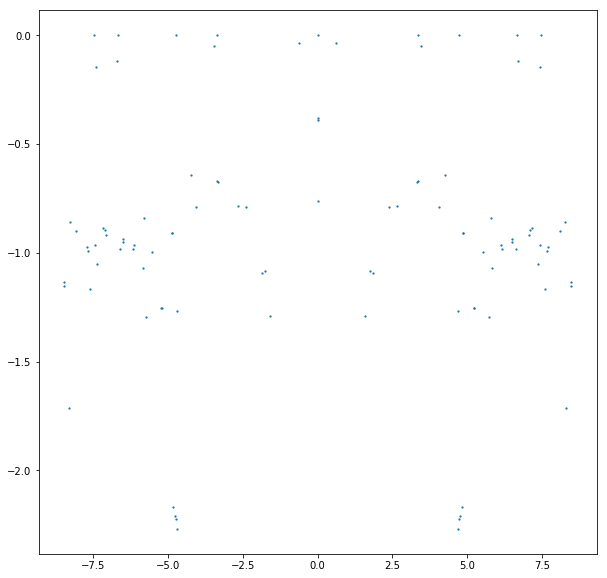

In [99]:
if test:
    exact_eig = []
    for m in range(length_2):
        for n in range(length_2):
            exact_eig.append(sqrt(float(m**2 + n**2)))
            exact_eig.append(-sqrt(float(m**2 + n**2)))
    sorted_exact_eig = np.sort(exact_eig)
    exact_length = len(exact_eig)
    coor = 5 # this is to put the two plots in phase.
    x = np.arange(length)
    y = np.arange(exact_length-2*corr)
    mpl.figure(figsize=(10,10)) 
    #print("Exact:    {}".format(sorted_exact_eig))
    mpl.plot(x,i_computed_eigenvalues[:length],'g^',y,sorted_exact_eig[corr:exact_length-corr],'r.')
else: 
    mpl.figure(figsize=(10,10))
    mpl.scatter(i_computed_eigenvalues[:length],r_computed_eigenvalues[:length],s=1.5)

In [121]:
r, c, re, ce = eigensolver.get_eigenpair(3)
r1, c1, re1, ce1 = eigensolver.get_eigenpair(3)
print('The eigenvalue is: ({},{})'.format(c,r))


# save for plotting

ur = Function(W)
ui = Function(W)
ur.vector()[:] = re
ui.vector()[:] = ce

(u_pr, p_pr) = ur.split()
(u_pi, p_pi) = ui.split()

# Re-scale solution to have L2 norm unity.
u_i = Function(V)
u_r = Function(V)

square = (u_pr*u_pr+u_pi*u_pi)*dx
#square = inner(uu,uu)*dx
L2_inv = 1./sqrt(assemble(square))

u_r = project(L2_inv*u_pr,V)
u_i = project(L2_inv*u_pi,V)
    
#square = u_n*u_n*dx
square = (u_r*u_r + u_i*u_i)*dx
print("This should be unit = %2.2f"%assemble(square))

# Save solution to file in VTK format


vtkfile_ur = File('Cavity/ur.pvd')
vtkfile_ui = File('Cavity/ui.pvd')

    
vtkfile_ur << u_r    
vtkfile_ui << u_i 


The eigenvalue is: (0.0,-0.3802847320599507)
Calling FFC just-in-time (JIT) compiler, this may take some time.
This should be unit = 1.00


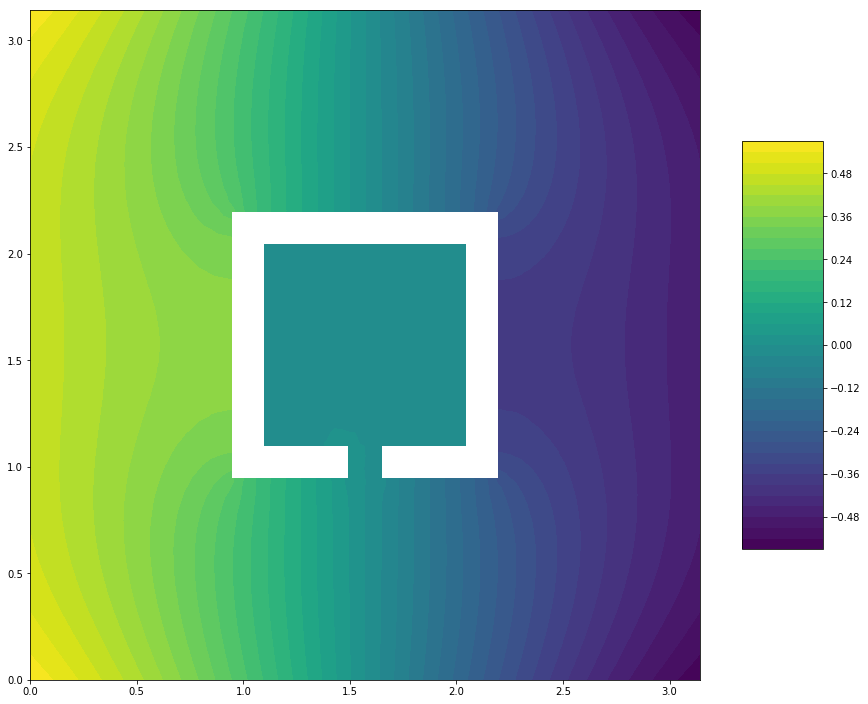

In [122]:
#Plot eigenfunction and mesh
fig = mpl.figure(figsize=(15,15))

modulo = plot(u_r)

plot(u_r)
#plot(u_i)
#plot(mesh)
fig.colorbar(modulo, shrink=0.5, aspect=5)
